# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
import numpy as np
import xarray as xr
import poligrain as plg
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ds_pws = xr.open_dataset('OpenSense_PWS_example_format_data.nc')

#slice to one month
ds_pws = ds_pws.sel(time = slice('2017-07-01','2017-07-31'))

## Calculate distance matrix

In [3]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    x=ds_pws.longitude, y=ds_pws.latitude, target_projection="EPSG:25832"
)

In [4]:
distance_matrix = plg.spatial.calc_point_to_point_distances(ds_pws, ds_pws)

## SO filter (fixed evaluation period only)

In [5]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.35 # 0.15 original (gives very few SO-flags)
beta = 0.2
n_stat = 5
max_distance = 10e3 # Boolean 2D data array, defining neihbours within max_distance for all stations
dbc = 1

In [6]:
# initalize data variables
ds_pws['so_flag'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))
ds_pws['mean_corr_nbrs'] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

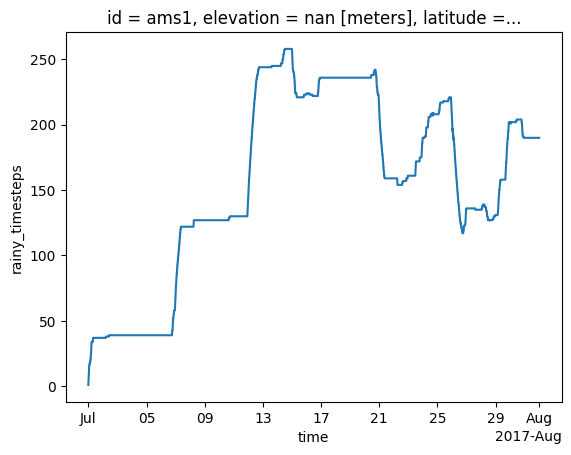

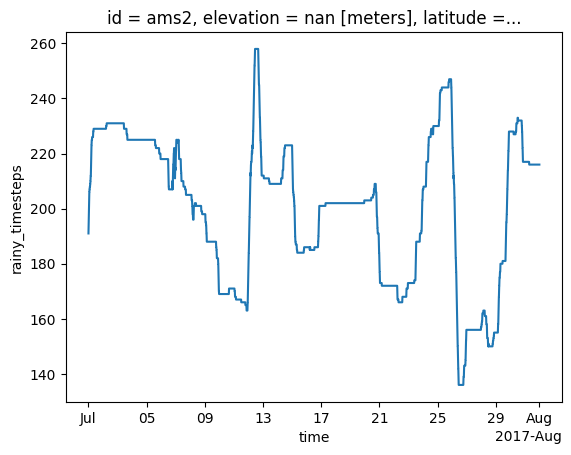

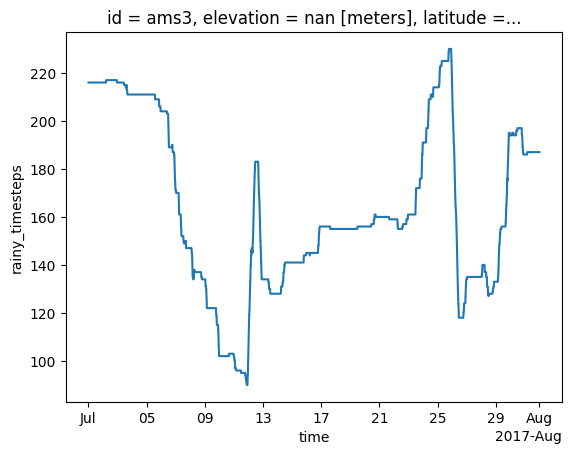

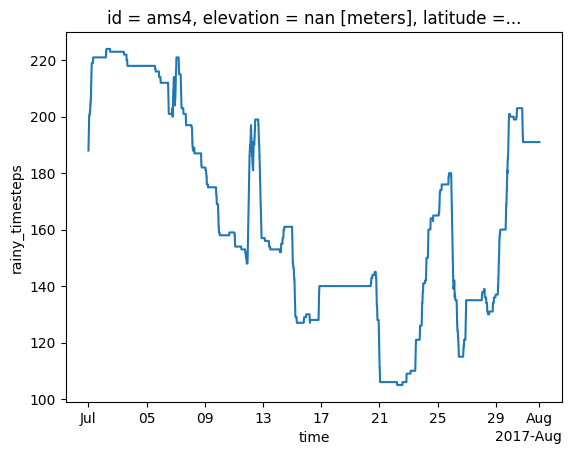

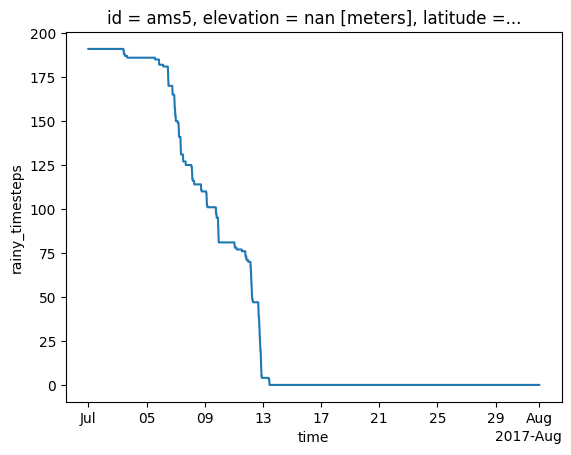

In [30]:
for i in [0,1,2,3,4]:
    plt.figure()
    ds_pws.rainy_timesteps.isel(id = i).plot()

In [34]:
ds_pws.rainy_timesteps.sel(id = "ams5").data

array([191., 191., 191., ...,   0.,   0.,   0.])

In [27]:
s_station

id      time               
ams1    2017-07-01 00:00:00    0.101
        2017-07-01 00:05:00    0.202
        2017-07-01 00:10:00    0.101
        2017-07-01 00:15:00    0.202
        2017-07-01 00:20:00    0.101
                               ...  
ams134  2017-07-31 23:35:00    0.000
        2017-07-31 23:40:00    0.000
        2017-07-31 23:45:00    0.000
        2017-07-31 23:50:00    0.000
        2017-07-31 23:55:00    0.000
Name: rainfall, Length: 1196352, dtype: float64

In [82]:
%%time

# this takes 35 sec for one station, for the whole time series, when the time series is one month long
i = 0
ds_station = ds_pws.isel(id=i) 
pws_id = ds_station.id.values

# one bias correction factor per station, iteratively updated PER TIME STEP ??
BCF_prev = dbc

# picking stations within max_distnance, excluding itself, for the whole duration of the time series
neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

#create data set for neighbors
ds_neighbors = ds_pws.sel(id=neighbor_ids)

# s_station = ds_station.rainfall.to_series()
# s_neighbors = ds_neighbors.rainfall.to_series()

ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint) 
# matches = ((s_station > 0) & (s_neighbors > 0)).sum()

# matches

MemoryError: Unable to allocate 13.1 GiB for an array with shape (196416, 8928) and data type float64

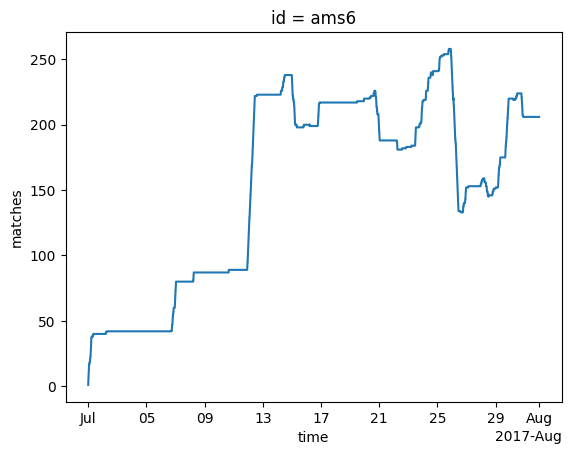

In [80]:
ds_so_filter.matches.isel(id = 4).plot()

In [68]:
# DO NOT DELETE THIS CELL
# overlap_counts = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).sum())

In [83]:
def so_filter(da_station, da_neighbors, window_length):
    
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()

    corr = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)
    rainy_timesteps = (s_neighbors > 0).rolling(window_length, min_periods=1).sum()
    # matches = ((s_station > 0) & (s_neighbors > 0).sum()

    # the row below is what takes time to do, the rest is very fast
    # matches = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).sum())

    # this makes the whole thing explode
    # matches = s_neighbors.apply(lambda col: ((s_station > 0) & (col > 0)).rolling(window_length, min_periods=1).sum())
    ds = xr.Dataset.from_dataframe(pd.DataFrame({'corr': corr}))
    ds['rainy_timesteps'] = xr.DataArray.from_series(rainy_timesteps)
    ds['matches'] = xr.DataArray.from_series(matches)
    
    return ds

In [10]:
%%time

for i in [0,1,2,3,4]: # range(len(ds_pws.id)):

    # create data set for station i
    ds_station = ds_pws.isel(id=i) 
    pws_id = ds_station.id.values

    # one bias correction factor per station, iteratively updated PER TIME STEP ??
    BCF_prev = dbc

    # picking stations within max_distnance, excluding itself, for the whole duration of the time series
    neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]

    #create data set for neighbors
    ds_neighbors = ds_pws.sel(id=neighbor_ids)

    # run so-filter
    ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)

    # if there are no observations in the time series, filter cannot be applied
    if ds_pws.rainfall.sel(id=pws_id).isnull().all():
        print(pws_id, " has no data")
        ds_pws.so_flag[i, :] = -1
        
    # if there are not enough stations nearby, filter cannot be applied
    elif (len(neighbor_ids) < n_stat):
        # print(pws_id, "has less than", n_stat, "neighbors")
        ds_pws.so_flag[i, :] = -1

    elif
    xr.where(ds_so_filter.rainy_timesteps < mmatch, -2, -4)
    
    elif ds_so_filter.enough_matches.isel(id = i) == False:
    #    ds_pws.so_flag[i, :] = -1
    
     #enough_matches = rainy_timesteps < mmatch
    # matches = rainy_timesteps(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
    # ds_pws.rainy_timesteps = matches
    # ds_pws['so_flag'] = xr.where(matches.rainy_timesteps < mmatch, -2, -4)
    
    #else: 
        # print("calculating SO-flag for", pws_id)
        #ds_so_filter = so_filter(ds_station.rainfall, ds_neighbors.rainfall, window_length=mint)
        #mean_corr = ds_so_filter.corr.mean(dim = "id", skipna = True)
        #ds_pws.mean_corr_nbrs[i, :] = mean_corr
        #ds_pws.so_flag[i,:] = xr.where(ds_pws.mean_corr_nbrs.isel(id = i) < gamma , -1, 0) 


ams5  has no data
CPU times: total: 562 ms
Wall time: 549 ms


In [84]:
# xr.where(ds_so_filter.rainy_timesteps < mmatch, -2, -4)

## Bias (next step to fix - how to calculate ROLLING bias?) 

In [7]:
# initialize 
ds_pws["bias"] = xr.DataArray(np.ones((len(ds_pws.id), len(ds_pws.time)))*-999, dims=("id", "time"))

In [21]:
#bias for the whole time series with nbrs, one station
i = 0

pws_id = ds_station.id.values
ds_station = ds_pws.isel(id=i) 

neighbor_ids = distance_matrix.id.data[(distance_matrix.sel(id=pws_id) < max_distance) & (distance_matrix.sel(id=pws_id) > 0)]
ds_neighbors = ds_pws.sel(id=neighbor_ids)

delta_r = ds_station.rainfall - ds_neighbors.rainfall
bias = np.nanmean(delta_r) / np.nanmean(ds_neighbors.rainfall)

# how to make rolling bias? 

In [16]:
def bias(station_rainfall, reference_rainfall):
    delta_r = station_rainfall - reference_rainfall
    return np.nanmean(delta_r) / np.nanmean(reference_rainfall)

In [ ]:
def bias_test(da_station, da_neighbors, window_length):
    s_station = da_station.to_series()
    s_neighbors = da_neighbors.to_series()
    bias = np.nanmean(delta_r) / np.nanmean(reference_rainfall)
    # roll_bias = s_station.rolling(window_length, min_periods=1).corr(s_neighbors)

In [17]:
ds_bias = bias(ds_station.rainfall, ds_neighbors.rainfall, window_length)
# bias_list.append(ds_corr.corr.median(dim='id'))

# Update bias or keep bias 

In [16]:
# ds_pws['median_corr'] = (('id', 'time'), corr_list)

In [17]:
# add flags to dataset
# ds_pws["bias"] = (("id", "time"), biascorrectiontable)

In [18]:
# ds_pws.to_netcdf('C:/Users/a002461/OPENSENSE/data/OpenSense_PWS_example_format_data_SO_flags.nc')

In [19]:
#so_flag = pypwsqc.flagging.so_filter(
#    ds_pws.rainfall,
#    ds_pws.nbrs_not_nan,
#    ds_pws.reference,
#    distance_matrix,
#    mint = 4032,
#    mrain = 100,
#    mmatch = 200,
#    gamma = 0.15,
#   beta = 0.2,
#    n_stat = 5,
#    max_distance = 10e3,
#)